# Exploration of the binomial model for directionality

Based on the relative orientations of the reads of a read pair, we classify read pairs as either *simple* or *twisted*. For Hi-C and capture Hi-C data, there are roughly the same number of simple and twisted read pairs, after artifact read pairs (un-ligated, self-ligated, etc.) have been filtered out. On the other hand, there can be extreme imbalances of simple and twisted read pairs within individual interactions. We use a binomial test with $p=0.5$ to assess imbalances within individual interactions for statistical significance. For example, if an interaction has $s=5$ simple and $t=10$ twisted read pairs, then we use

$$B(k=s, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

with a certain P-value threshold to decide whether the interaction is directed or not. One problem with this approach is that interactions have different total numbers of read pairs ($n$) and that the power of the test increases with $n$.

In this Jupyter Notebook we examine the relationship between $n$ and the power of the test. For this purpose, we simulate interactions with simple and twisted read pairs by drawing the total number of read pairs ($n$) from a uniform ditribution and then choosing randomly a number of simple read pairs ($s<=n$) using our binomial model with $p=0.5$. Then we evaluate the simulated interactions with regard to directionality, also using our binomial model, and determine the number of directed interactions for each $n$ at a specified P-value threshold.

In addition, we determine the empirical distribution in a real dataset.


## Setting up the notebook

In [295]:
import sys
import os
import matplotlib.pyplot as plt
import scipy, scipy.stats
%matplotlib inline

# Import BinomialInteractionModel
sys.path.append("..")
from diachr import BinomialInteractionModel

## Simulation of interactions

First we create an object of class `BinomialInteractionModel`. Initially, the P-value threshold at which interactions are classified as directed is set and the minimum number of read pairs required for significance is determined. For example, if the threshold is $0.05$, then at least 5 read pairs are required for significance, because the most extreme P-value for 4 read pairs is already greater than the threshold ($0.0625$). We do not simulate interactions that have too few read pairs to be significant.





In [152]:
p_value_cutoff=0.05
bim = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.05.
	[INFO] Smallest n: 5 read pairs (0.03125)
[INFO] Parameters
	[INFO] _out_prefix: OUTPREFIX
	[INFO] _p_value_cutoff: 0.05
	[INFO] _n_indef: 5
	[INFO] _pv_indef: 0.03125


Next we simulate the interactions. To do this, we need to set two parameters:

1. The maximum number of read pairs per interaction (`n_max`)
2. The number of interactions to be simulated (`i_num`)

We use the numpy function `randint` in order draw `i_num` total read pair numbers from a uniform distribution:

`np.random.randint(low = self._n_indef, high = n_max  + 1, size = i_num)`

Note that we only draw numbers that are greater or equal to the previously determined number of read pairs that are required for significance (`low = self._n_indef`). For the sake of efficiency, we draw all random numbers at once.

Then we determine for each $n$=`_n_indef`, ..., `n_max` how often it was drawn (`i`) and draw a corresponding number of simple read pair counts from the binomial distribution:

`simple_count_list = list(binom.rvs(n, p = 0.5, size = i))`

For each simple count, we determine a P-value according to our binomial model with $p=0.5$. If the P-value is below the threshold, then we increment the number of significant interactions for the current $n$ by 1.

The function below implements the simualtion and returns three lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_sim_list`: List with numbers of simulated interactions for each $n$
3. `n_sig_list`: List with numbers of significant simulated interactions for each $n$

Note that all three lists are `n_max+1` in length and the index corresponds to n.

Run the cell below to perform the simulation.

In [153]:
n_max=400
i_num=10000000
n_list, n_sim_list, n_sig_list = bim.count_simulated_interactions(n_max=n_max, i_num=i_num)

[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


Note that we are simulating a very large number of interactions. The reason for this is that we simulate the interactions according to our null model, with $p=0.5$, which is why the number of significant interactions is minimal. Since we want to investigate the distribution of the significant interactions on different $n$, we need as many significant interactions as possible.

Run the cell below to create a plot with the total numbers of simulated interactions for each n.

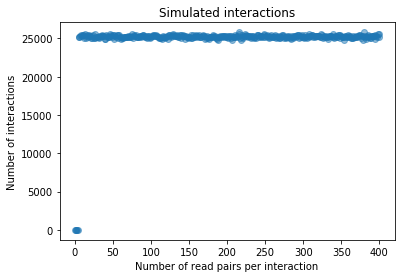

In [154]:
plt.scatter(n_list, n_sim_list, alpha=0.5)
plt.title('Simulated interactions')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.show()

In the plot above it can be seen that the simulated interactions are evenly distributed across the different $n$. It can also be seen that no interactions are simulated for very small $n$. These are those interactions that cannot be significant at the given P-value threshold.

Run the cell below to create a plots with the total numbers of simulated *significant* interactions for each n. Both plots show the same data. The top one is a scatterplot and the bottom one is a line plot. The line plot makes the periodic fluctuations better visible.

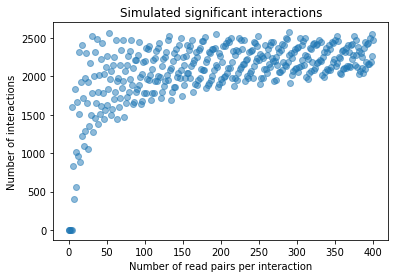

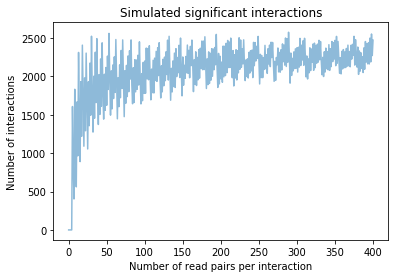

In [155]:
# Scatterplot
plt.scatter(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.show()
# Line plot
plt.plot(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.show()

In the two plots above it can be seen that interactions with smaller read pair counts are less often significant as interactions with larger read pair counts. In addition periodic fluctuations can be seen which, overall, become smaller for larger $n$.

Our interpretation of these results is that the binomial test has less power for smaller $n$ as compared to larger $n$. We attribute the periodic fluctuations to the discrete nature of the binomial distribution. We find that our test for directionality of interactions is not independent of $n$.

Now we repeat the simulation for a smaller P-value threshold.

In [99]:
p_value_cutoff=0.0019
bim_2 = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)
n_max=400
i_num=100000000
n_list, n_sim_list, n_sig_list = bim_2.count_simulated_interactions(n_max=n_max, i_num=i_num)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.0019.
	[INFO] Smallest n: 10 read pairs (0.0009765625)
[INFO] Parameters
	[INFO] _out_prefix: OUTPREFIX
	[INFO] _p_value_cutoff: 0.0019
	[INFO] _n_indef: 10
	[INFO] _pv_indef: 0.0009765625
[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


Run the cell below to create a plot with the total numbers of simulated interactions for each n.

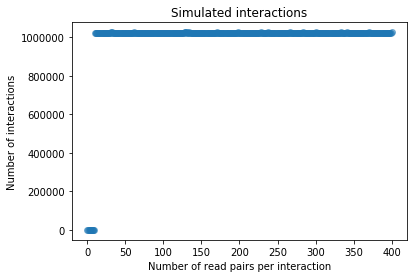

In [97]:
plt.scatter(n_list, n_sim_list, alpha=0.5)
plt.title('Simulated interactions')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.show()

If the maximum number of read pairs per interactions (`n_max`) and the number of simulated interactions (`i_num`) remains unchanged, then we get a comparable distribution of interactions across the different $n$.

Run the cell below to create a plots with the total numbers of simulated significant interactions for each n.

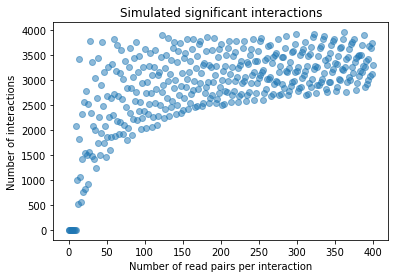

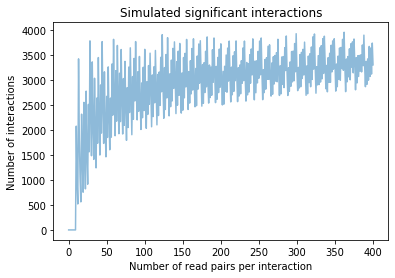

In [98]:
# Scatterplot
plt.scatter(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.show()
# Line plot
plt.plot(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.show()

Because we used a much smaller P-value threshold, we also have less significant interactions. However, the picture is similar to the first simulation. Interactions with fewer read pairs are less often significant as interactions with many read pairs. There are fluctuations that decrease with increasing $n$, but do not look as regular as in the first simulation. We attribute the lower regularity of the fluctuations to the smaller number of significant interactions that result from the smaller P-value threshold.

If we simulate a lot more interactions (takes a long time), the fluctuations look more regular again.

One consequence that drew from this simulation study was that we do not simply compare directed interactions with all undirected interactions, but rather with *undirected reference interactions*, which we select in such a way that they are comparable to directed interactions in terms of the distribution of $n$. The idea is that, in this way, both sets of interactions will be similarly affected by the irregularities we found.

## Binomial distributions for different n and a fixed P-value threshold

In this section of the notebook, we try to better understand the observed periodic fluctuations in the significant interactions for different $n$.

For given interactions, we test the ratio of simple and twisted read pairs for statistical significance using a binomial test. When we do this, we use the same P-value threshold for all interactions, but interactions have different total numbers of read pairs ($n$). For different $n$, the test is based on different *discrete distributions*. On the other hand, the P-value refers to the sum of the probability densities, which can only be values between $0$ and $1$.

Let $d_k$ be the denstity for some $k\in \{1,...,n\}$. For every $n$, the P-value threshold corresponds to a certain $k_{max}$, so that the sum $\sum_{k=0}^{k_{max}}d_k$ is as large as possible and at the same time smaller than the threshold value. If we go from $n$ to $n+1$, then the distribution becomes broader, so that the densities for all possible $k$ become smaller. A distinction must be made between two cases:

1. $\sum_{k=0}^{k_{max}+1}d_k$ *remains greater* than the P-value threshold

2. $\sum_{k=0}^{k_{max}+1}d_k$ *becomes smaller* than the P-value threshold

In the first case, we keep $k_{max}$. Since the interval remains the same and the densities become smaller overall, it becomes less likely to observe a significant $k<=k_{max}$ under the model with $n+1$. In the second case, the sum $\sum_{k=0}^{k_{max}}d_k$ becomes smaller too because the distribution becomes broader overall, but the density for $d_{k_{max}+1}$ is added to this sum. Overall, this makes it more likely to observe a significant $k<=(k_{max}+1)$ under the model with $n+1$.

For illustration purposes, we generate binomial distributions for $n=1, ..., N$. For each $n$, we determine the largest $k_{max}$ for which $\sum_{k=0}^{k_{max}}d_k$ is smaller than the half of a fixed P-value threshold. In the context of interactions, this $k$ corresponds to the largest number of simple read pairs for which the test is still significant at the given $n$. Conversely, $n-k$ corresponds to the number of twisted read pairs, which is why we are using only the half of the theshold. For each $n$, we keep track of all $k_{max}$ as well as the corresponding $\sum_{k=0}^{k_{max}}d_k$ and show them at the end in a combined plot. Optionally, each individual distribution can be plotted.

The function in cell below takes three arguments:

1. `N` - Binomial distributions for $n=1, ..., N$ will be generated
2. `pvt` - Fixed P-value threshold
3. `CREATE_DIST_PLOTS` - Set this to `True` to plot every single binomial distribution for $n = 1, ..., N$, otherwise only one combined plot will be generated that is explained further below.

Execute the cell to make the function available.

In [368]:
def analyze_N_binomial_distributions_with_fixed_p_thresh(N=40, pvt=0.05, CREATE_DIST_PLOTS=True):

    # Intit lists for the final plot
    n_list = []
    d_sum_prev_list = []
    k_pvt_list = []

    # Create binomial distributions for n = 1, ..., N
    for n in range(1,N+1):

        # Get list of densities for current n
        x = list(scipy.arange(0,n+1,1.0))
        pmf = scipy.stats.binom.pmf(x,n,0.5)

        # Find largest k for which the sum of densities from 0 up to k is below the P-value threshold    
        d_sum = 0.0
        d_sum_prev = 0.0
        k_pvt = 0
        for density in pmf:
            d_sum = d_sum + density
            if pvt/2 < d_sum:
                break
            else:
                k_pvt += 1
                d_sum_prev=d_sum

        # Collect determined values for the final plot
        n_list.append(n)
        d_sum_prev_list.append(d_sum_prev)
        k_pvt_list.append(k_pvt)

        # Create distribution plot for current n
        if CREATE_DIST_PLOTS:
            if d_sum_prev > 0.0:
                color = 'blue'
            else:
                color = 'red'
            plt.title('p_tresh=' + str(pvt) + \
              ', n=' + str(n) + \
              ', d_sum=' + "{:.4f}".format(d_sum_prev) + \
              ', k_pvc=' + str(k_pvt))
            plt.xlabel('n')
            plt.ylabel('Density')
            plt.xlim(-1,N)
            plt.ylim(0,0.5)
            plt.bar(x,pmf,color=color)
            plt.vlines(0,0,N)
            plt.vlines(n,0,N)
            plt.axvspan(0, k_pvt, facecolor='b', alpha=0.2)
            plt.axvspan(n-k_pvt, n, facecolor='b', alpha=0.2)
            plt.show()


    # Create final plot with two y-axes, one for d_sum and one for k_pvt
    fig, ax1 = plt.subplots()
    color = 'blue'
    ax1.set_xlabel('n')
    ax1.set_ylabel('P-value', color=color)
    ax1.plot(n_list, d_sum_prev_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'black'
    ax2.set_ylabel('$k_{max}$', color=color)  # we already handled the x-label with ax1
    ax2.scatter(n_list, k_pvt_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


First we look only at the distributions for $n=1,...,10$ so that the individual transitions from $n$ to $n+1$ can be seen better. Execute the cell below.

With the selected P-value threshold, there are no significant interactions for $n=1,...,5$. This is because even the most extreme outcomes ($k=0$) leads to a P-value that is above the threshold.

For $n=6$, the test can be significant for the first time, where $k_{max}=1$ and the P-value is $0.0156$.

For $n=7$, $k_{max}=1$ remains unchanged and the P-value goes down to $0.0078$. Note that it has become less likely to observe $k=1$ or $k=0$. That's because the distribution has broadened. Case one has occured.

For $n=8$, $k_{max}=1$ remains unchanged and the P-value goes down to $0.0039$. Case one has occured.

For $n=9$, $k_{max}$ increases  to $2$ and the P-value goes up to $0.0195$. Case two has occured.

For $n=10$, $k_{max}=2$ remains unchanged and the P-value goes down to $0.0107$. Case one has occured. 

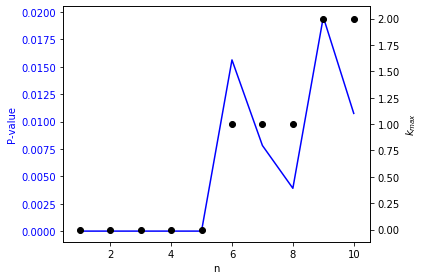

In [369]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=10, pvt=0.05, CREATE_DIST_PLOTS=False)

Next we look at the distributions for $n=1,...,40$. Execute the cell below.

A regular pattern can be seen in which case 1 always occurs two or three times and the case 2 occurs once.

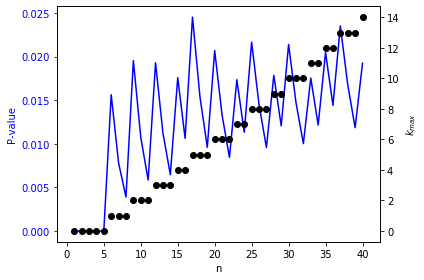

In [373]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=40, pvt=0.05, CREATE_DIST_PLOTS=False)

Now we are using the same parameters that we used for the first simulation of interactions.

The shape of the curve for the P-values is strongly reminiscent of the curve for simulated significant interactions.

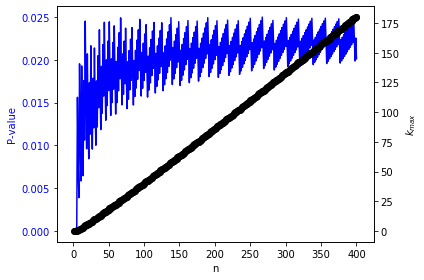

In [383]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=400, pvt=0.05, CREATE_DIST_PLOTS=False)

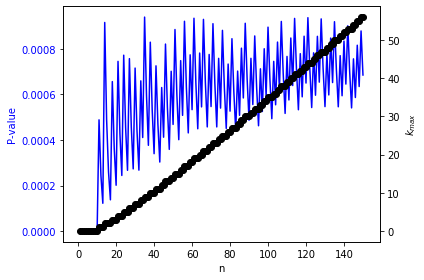

In [387]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=150, pvt=0.0019, CREATE_DIST_PLOTS=False)

## Distribution of n for empircal data

In this section of the notebook, we examine the distribution of $n$ for a real dataset from a capture Hi-C experiment for megakaryocytes. For this dataset, we defined all interactions with a P-value less than $0.0019$ as directed interactions (**DI**). Then we determined the distribution of $n$ for DI and selected a set of undirected reference interactions with a comparable distribution of $n$ (**UIR**) from all undirected interactions (**UI**).

For this analysis, a file in *Enhanced Interaction Format* is expected as input, with the respective interaction category in the third column.

In [47]:
ie_file = '../results/06_select_reference_interactions/MK/MK_enhanced_interaction_file_with_di_ui_and_uir.tsv.gz'
if not os.path.exists(iefile):
    raise FileNotFoundError("Could not find IE file")

The function below implements the determination of the empirical distributions of $n$ for DI, UIR and UI and returns four lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_di_list`: List with numbers of DI for each $n$
3. `n_uir_list`: List with numbers of UIR for each $n$
4. `n_ui_list`: List with numbers of UI for each $n$

In [122]:
n_list, n_di_list, n_uir_list, n_ui_list = bim_2.count_significant_empirical_interactions(ei_file=ie_file)

	[INFO] Processed 1000000 interactions ...
	[INFO] Processed 2000000 interactions ...
	[INFO] Processed 3000000 interactions ...
	[INFO] Processed 4000000 interactions ...
	[INFO] Processed 5000000 interactions ...


Execute the cell below to determine the total number of DI and plot the distribution of $n$.

Total number of DI: 209192


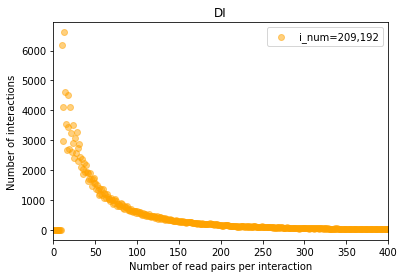

In [130]:
di_sum = 0
for i in n_di_list:
    di_sum += i
print("Total number of DI: " + str(di_sum))
plt.scatter(n_list, n_di_list, alpha=0.5, color=(255/255,163/255,0/255,1),label='i_num=' + str("{:,d}".format(di_sum)))
plt.title('DI')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.xlim(0,400)
plt.legend()
plt.show()

Execute the cell below to determine the total number of UIR and plot the distribution of $n$.

Total number of UIR: 208818


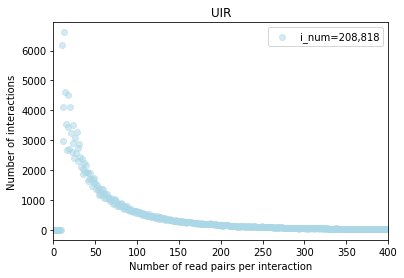

In [131]:
uir_sum = 0
for i in n_uir_list:
    uir_sum += i
print("Total number of UIR: " + str(uir_sum))
plt.scatter(n_list, n_uir_list, alpha=0.5, color=(171/255,215/255,230/255,1),label='i_num=' + str("{:,d}".format(uir_sum)))
plt.title('UIR')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.xlim(0,400)
plt.legend()
plt.show()

It can be seen that DI and UIR have almost the same number of interactions. Furthermore, the distribution of $n$ is almost identical for DI and UIR.

Execute the cell below to determine the total number of UI and plot the distribution of $n$.

Total number of UI: 4831489


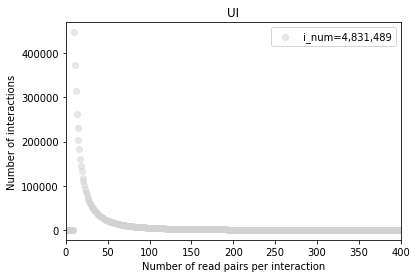

In [132]:
ui_sum = 0
for i in n_ui_list:
    ui_sum += i
print("Total number of UI: " + str(ui_sum))
plt.scatter(n_list, n_ui_list, alpha=0.5, color=(210/255,210/255,210/255,1),label='i_num=' + str("{:,d}".format(ui_sum)))
plt.title('UI')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.xlim(0,400)
plt.legend()
plt.show()

It can be seen that there are many more UI than DI and UIR. It can also be seen that the distribution is shifted towards smaller $n$.

ValueError: x and y must be the same size

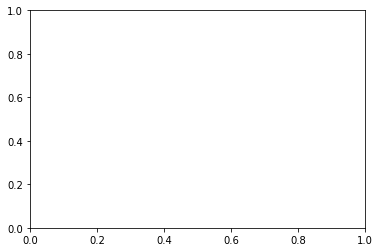

In [198]:
# Get relaative frequencies and common maximum for y-axis
max_rel=0
di_rel = []
for i in n_di_list:
    di_rel.append(i/di_sum)
    if max_rel < i/di_sum:
        max_rel=i/di_sum
uir_rel = []
for i in n_uir_list:
    uir_rel.append(i/uir_sum)
    if max_rel < i/uir_sum:
        max_rel=i/uir_sum
ui_rel = []
for i in n_ui_list:
    ui_rel.append(i/ui_sum)
    if max_rel < i/ui_sum:
        max_rel=i/ui_sum

# Plot distributions of n for DI, UIR and UI with a common y-axis
plt.scatter(n_list, di_rel, alpha=0.5, color=(255/255,163/255,0/255,1))
plt.xlim(0,400)
plt.ylim(0,max_rel)
plt.title('DI')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Relative frequency of interactions')
plt.show()

plt.scatter(n_list, uir_rel, alpha=0.5, color=(171/255,215/255,230/255,1))
plt.xlim(0,400)
plt.ylim(0,max_rel)
plt.title('UIR')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Relative frequency of interactions')
plt.show()

plt.scatter(n_list, ui_rel, alpha=0.5, color=(210/255,210/255,210/255,1))
plt.xlim(0,400)
plt.ylim(0,max_rel)
plt.title('UI')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Relative frequency of interactions')
plt.show()

